# Loading Libraries

In [175]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout, Lambda
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

# Loading CIFAR-10 Dataset

In [176]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Getting Number of classes and defining class labels

In [177]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

## Reshaping and Normalizing the data

Convert class vectors to binary class matrices:

In [178]:
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

Normalizing the data into the range between -1 and 1, because Generator is using tanh as activation function:

In [179]:
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)


X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

# Make labled and unlabled batches

In [180]:
def make_labeled_batch(x_train, y_train, batch_size, num_labeled):
    idx = np.random.randint(0, num_labeled, size=batch_size)
    images = x_train[idx]
    labels = y_train[idx]
    
    return images, labels

def make_unlabled_batch(x_train, batch_size, num_labeled):
    idx = np.random.randint(num_labeled, x_train.shape[0], batch_size)
    unlabled_batch = x_train[idx]

    return unlabled_batch

# Define Model

## Generator

Define Generator Function: Here we define generator network which is composed of 5 layers. First layer is a fully connected. Then we use 3 transposed convolution layers, and all these layers use LeakyRelu as activation function and also use Batch Normalization. The last layer is a transposed convolution layer but it uses tanh as its activation function.

In [181]:
def build_generator(z_dim):
  generator = Sequential()

  # FC: 
  generator.add(Dense(2*2*512, input_shape=(z_dim,)))
  generator.add(Reshape((2, 2, 512)))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 1: 
  generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 2: 
  generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 3: 
  generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 4: 
  generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                                activation='tanh'))
  z = Input(shape=(z_dim,))
  img = generator(z)

  return Model(z, img)

Defining inputs of build_generator function:

In [182]:
# latent space dimension
latent_dim = 100

Call build_generator function:

In [183]:
generator = build_generator(latent_dim)

Visualization of Generator model:

In [184]:
generator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_31 (Sequential)   (None, 32, 32, 3)         4516739   
Total params: 4,516,739
Trainable params: 4,514,819
Non-trainable params: 1,920
_________________________________________________________________


# Discriminator

## Core Discriminator

Define Discriminator function: Here we define discriminator network which is composed of 4 convolution layers and and one fully connected layer after them and a Dense layer as output layer. All convolution layers use LeakyRelu as activation function and also use Batch Normalization. Fully connected layer is a Flatten layer and output layer is a Dense layer and returns the output of shape num_classes.

In [185]:
def build_core_discriminator():

  img_shape = X_train[0].shape

  discriminator = Sequential()

  # Conv 1:
  discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                          input_shape=(img_shape)))
  discriminator.add(LeakyReLU(0.2))

  # Conv 2:
  discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  # Conv 3: 
  discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  # Conv 4: 
  discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  # FC
  discriminator.add(Flatten())

  # Output
  discriminator.add(Dense(num_classes))

  return discriminator

Call build_core_discriminator function:

In [186]:
core_discriminator = build_core_discriminator()

Visualization of Core_Discriminator model:

In [187]:
core_discriminator.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_47 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_48 (Batc (None, 4, 4, 256)       

## Supervised Discriminator

In [188]:
def build_supervised_discriminator(discriminator_net):
    
    model = Sequential()
    
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    
    return model

## Build Supervised Discriminator

In [189]:
supervised_discriminator = build_supervised_discriminator(core_discriminator)

## Unsupervised Discriminator

In [190]:
def predict(x):
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        
        return prediction
        
def build_unsupervised_discriminator(discriminator_net):
    
    model = Sequential()
    
    model.add(discriminator_net)
    model.add(Lambda(predict))
    
    return model

## Build UnSupervised Discriminator

In [191]:
unsupervised_discriminator = build_unsupervised_discriminator(core_discriminator)
unsupervised_discriminator.trainable = False

# Compile and Build SGAN Model

## Compile Supervised and Unsupervised Discrimnators

In [192]:
supervised_discriminator.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
unsupervised_discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Combine UnSupervised Discriminator and Generator and build SGAN Model

In [193]:
SGAN = Sequential()
SGAN.add(generator)
SGAN.add(unsupervised_discriminator)

## Compile SGAN Model

In [194]:
SGAN.compile(loss='binary_crossentropy', optimizer=Adam())

# Training the Model

Here we train the SGAN model in several parts described below:
1. First make a batch with size 64 from 200 first data of train set and get their labels and get the rest of the data as unsupervised part data
2. Then we generate 64 data using Generator and train supervised discriminator on the generated batch and compute accuracy and loss for supervised discriminator
3. We train unsupervised on unlabled batch and compute discriminator loss for real data and also train it on generated images and compute compute discriminator loss for fake data.
4. Then we get the average of 2 mentioned losses and call it supervised discriminator loss
5. Then we again generate samples using generator and noise z and train SGAN on z and real vector which is all one and compute generator loss. 

In [195]:
d_accuracies = []
d_losses = []

def train(iterations, batch_size, sample_interval, num_labeled):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
       
        imgs, labels = make_labeled_batch(X_train, Y_train, batch_size, num_labeled)

        imgs_unlabeled = make_unlabled_batch(X_train, batch_size, num_labeled)
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        gen_imgs = generator.predict_on_batch(z)
        
        d_loss_supervised, accuracy = supervised_discriminator.train_on_batch(imgs, labels)
        d_loss_real = unsupervised_discriminator.train_on_batch(imgs_unlabeled, real)
        d_loss_fake = unsupervised_discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        g_loss = SGAN.train_on_batch(z, real)
        
        d_losses.append(d_loss_supervised)
        d_accuracies.append(accuracy)
        
        if iteration % sample_interval == 0:
            print('{} [D loss supervised: {:.4f}, acc: {:.2f}]'.format(iteration, d_loss_supervised, 100 * accuracy))
        
        if iteration % 3000 == 0:
          samples = 100
          x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

          plt.figure(figsize = (8,8))
          gs1 = gridspec.GridSpec(4, 4)
          # set the spacing between axes. 
          for k in range(samples):
              gs1.update(wspace=0.0025, hspace=0.0005) 
              plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
              plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

          plt.tight_layout()
          plt.show()

0 [D loss supervised: 8.2596, acc: 26.56]


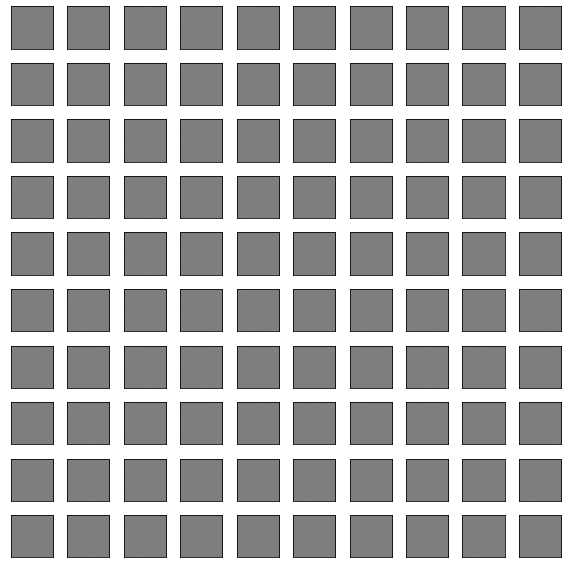

800 [D loss supervised: 0.0000, acc: 100.00]
1600 [D loss supervised: 0.0000, acc: 100.00]
2400 [D loss supervised: 0.0000, acc: 100.00]


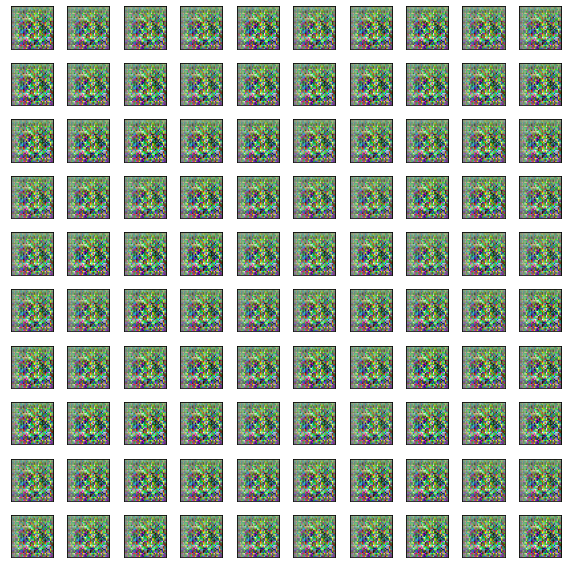

3200 [D loss supervised: 0.0000, acc: 100.00]
4000 [D loss supervised: 0.0000, acc: 100.00]
4800 [D loss supervised: 0.0000, acc: 100.00]
5600 [D loss supervised: 0.0000, acc: 100.00]


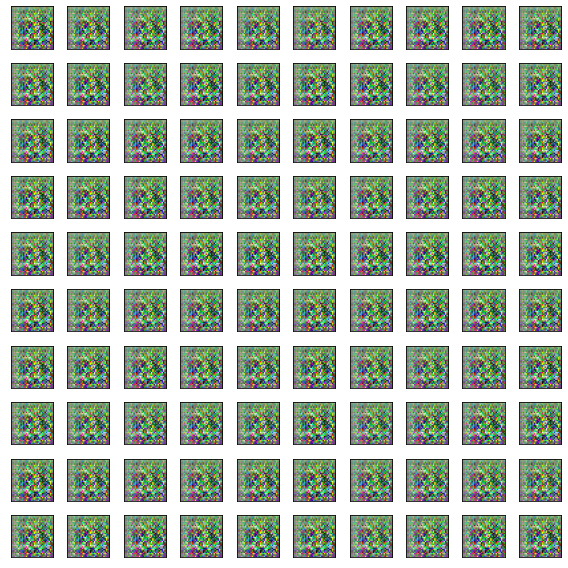

6400 [D loss supervised: 0.0000, acc: 100.00]
7200 [D loss supervised: 0.0000, acc: 100.00]
8000 [D loss supervised: 0.0000, acc: 100.00]
8800 [D loss supervised: 0.0000, acc: 100.00]


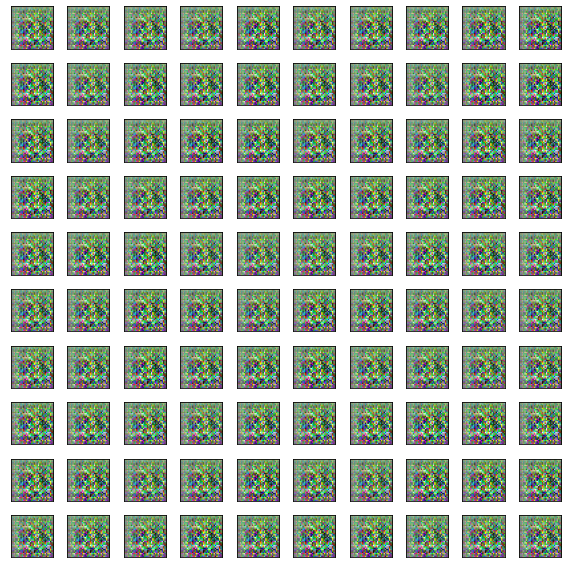

9600 [D loss supervised: 0.0000, acc: 100.00]
10400 [D loss supervised: 0.0000, acc: 100.00]
11200 [D loss supervised: 0.0000, acc: 100.00]
12000 [D loss supervised: 0.0000, acc: 100.00]


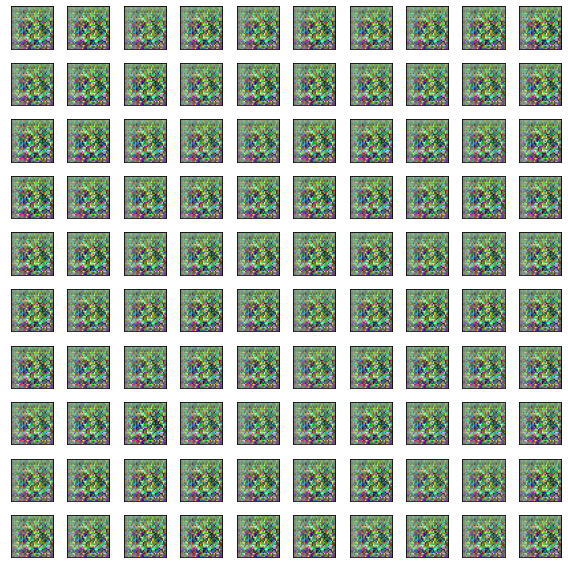

12800 [D loss supervised: 0.0000, acc: 100.00]
13600 [D loss supervised: 0.0000, acc: 100.00]
14400 [D loss supervised: 0.0000, acc: 100.00]


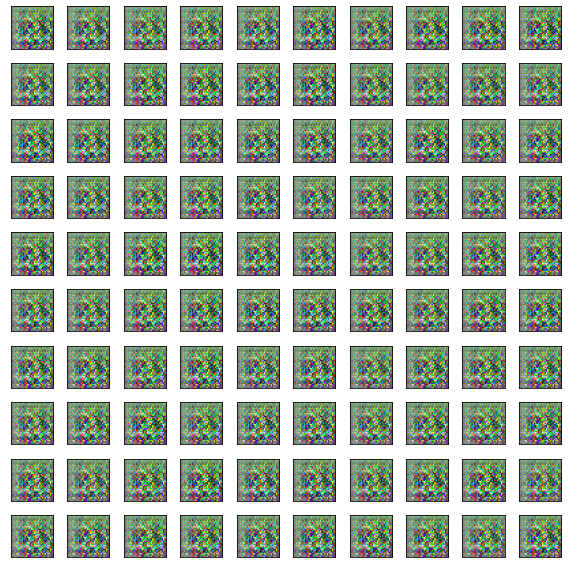

15200 [D loss supervised: 0.0000, acc: 100.00]
16000 [D loss supervised: 0.0000, acc: 100.00]


In [197]:
iterations = 16001
batch_size = 64
sample_interval = 800
num_labeled = 200
z_dim = 100

train(iterations, batch_size, sample_interval, num_labeled)

# Evaluate Model

## Model Accuracy on Train Data

In [198]:
_, accuracy = supervised_discriminator.evaluate(X_train, Y_train)
print('Test accuracty = {:.2f}%'.format(accuracy * 100))

50000/50000 [==============================] - 9s 175us/step
Test accuracty = 25.91%


## Model Accuracy on Test Data

In [201]:
x = X_test[0:]
y = Y_test[0:]
_, accuracy = supervised_discriminator.evaluate(x, y)
print('Test accuracty = {:.2f}%'.format(accuracy * 100))


10000/10000 [==============================] - 2s 172us/step
Test accuracty = 25.42%
